# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from scipy import stats as st


In [2]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable  — py widgetsnbextension
from catboost import CatBoostRegressor

Please specify one nbextension/package at a time


In [3]:
!pip install lightgbm
import lightgbm as ltb
from lightgbm import LGBMRegressor

In [4]:
# загрузка датасета
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [5]:
display(df)
df.info()
def count_missing(df): # функция для подсчета пропусков в столбцах
    nan = df.isnull().sum().sort_values(ascending=False) 
    missing_val = nan[nan > 0]
    return missing_val
print(count_missing(df))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

DateCrawled, DateCreated, LastSeen - нужно сменить тип на DateTime. В столбце Power есть нули, но не бывает машин с мощностью в 0 л.с., таких нулей 40 000. Нули в RegistrationMonth тоже выглядят странно, их 37 352, можно было бы подумать, что нумерация месяцев начинается с 0, но метод unique() возвращает значения от 0 до 12. 
Есть пропуски в NotRepaired, VehicleType, FuelType, Gearbox, Model - их много

In [6]:
# date and time
to_datetime = ['DateCrawled', 'DateCreated', 'LastSeen']
for col in to_datetime:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
df['Actuality'] = df['LastSeen'] - df['DateCreated'] 
df['Actuality']

0        14 days 03:16:57
1        14 days 01:46:50
2        22 days 12:47:46
3         0 days 17:40:17
4         6 days 10:17:21
               ...       
354364    0 days 10:42:49
354365   23 days 00:46:52
354366    6 days 18:17:12
354367   19 days 07:15:26
354368    4 days 12:45:21
Name: Actuality, Length: 354369, dtype: timedelta64[ns]

In [7]:
df['Actuality'] = df['Actuality'].astype(str)
def only_days(col):
    return col[:-14]
df['Actuality'] = df['Actuality'].apply(only_days)
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
df['Actuality'].unique()
df['Actuality'] = df['Actuality'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
 12  PostalCode         354369 non-null  int64 
 13  Actuality          354369 non-null  int32 
dtypes: int32(1), int64(7), object(6)
memory usage: 36.5+ MB


In [8]:
# нули в Power
df.query('Model == "golf" & RegistrationYear == 1993')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Actuality
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,14
158,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,0,65929,6
253,300,small,1993,manual,90,golf,150000,8,petrol,volkswagen,NaN,0,27412,10
2117,270,small,1993,manual,75,golf,150000,4,petrol,volkswagen,no,0,49152,2
2881,650,sedan,1993,auto,75,golf,150000,3,petrol,volkswagen,no,0,84186,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352364,750,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,23562,8
352734,900,small,1993,manual,60,golf,125000,8,petrol,volkswagen,no,0,44359,3
352866,250,sedan,1993,manual,60,golf,150000,3,petrol,volkswagen,no,0,31712,6
354047,1000,sedan,1993,manual,75,golf,150000,2,petrol,volkswagen,no,0,35767,2


In [9]:
#выбросы
df['Power'].max()

20000

Беглый поиск рейтинга самых мощных автомобилей указал, что рекордсменом является двигатель мощностью чуть более 1900 л.с., поэтому справедливо считать значения больше 2000 однозначными выбросами

In [10]:
df = df.query('Power < 2000')
golf_1993 = df.query('Model == "golf" & RegistrationYear == 1993')

От аномально больших значений избавиться получилось быстро, с нулями история чуть дольше

In [11]:
df.loc[df['Power'] == 0, ['Power']] = np.nan # превратим нули в пропуски

In [12]:
df['Power'] = np.where(df['Power'].isnull(), df['Model'].map(df.groupby('Model')['Power'].mean()), df['Power'])
                                                                                   
df.loc[df['Power'].isnull()].head() # пропусков стало примерно в два раза меньше                                                                           

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Actuality
115,0,small,1999,NaN,NaN,NaN,5000,0,petrol,volkswagen,NaN,0,37520,18
160,500,small,1999,manual,NaN,NaN,150000,0,petrol,renault,no,0,26969,13
260,450,NaN,2016,manual,NaN,NaN,150000,3,petrol,mitsubishi,no,0,59302,2
306,200,NaN,2009,NaN,NaN,NaN,10000,0,NaN,sonstige_autos,NaN,0,6493,3
308,1600,wagon,1999,manual,NaN,NaN,150000,6,petrol,bmw,no,0,41199,15


In [13]:
# заполним оставшиеся средним по типу кузова
df['Power'] = np.where(df['Power'].isnull(), df['VehicleType'].map(df.groupby('VehicleType')['Power'].mean()), df['Power'])
df.loc[df['Power'].isnull()]
# отлично, осталось 6 тысяч
# ну можно ещё по бренду производителя заполнить
df['Power'] = np.where(df['Power'].isnull(), df['Brand'].map(df.groupby('Brand')['Power'].mean()), df['Power'])
df.loc[df['Power'].isnull()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Actuality


In [14]:
df['Power'] = df['Power'].apply(round)

Вот теперь получилось совсем избавиться от пропусков в этом столбце

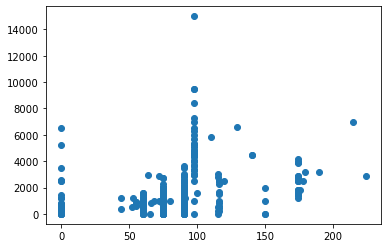

In [15]:
plt.scatter(golf_1993['Power'], golf_1993['Price'])

In [16]:
# год регистрации
df['RegistrationYear'].value_counts().tail(75)
df = df.query('RegistrationYear > 1910 & RegistrationYear < 2016')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329969 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              329969 non-null  int64 
 1   VehicleType        316535 non-null  object
 2   RegistrationYear   329969 non-null  int64 
 3   Gearbox            313473 non-null  object
 4   Power              329969 non-null  int64 
 5   Model              313728 non-null  object
 6   Kilometer          329969 non-null  int64 
 7   RegistrationMonth  329969 non-null  int64 
 8   FuelType           306498 non-null  object
 9   Brand              329969 non-null  object
 10  NotRepaired        269724 non-null  object
 11  NumberOfPictures   329969 non-null  int64 
 12  PostalCode         329969 non-null  int64 
 13  Actuality          329969 non-null  int32 
dtypes: int32(1), int64(7), object(6)
memory usage: 36.5+ MB


In [17]:
# NotRepaired - важный столбец, но пропуски в нем нужно заполнить значением "unknown"
cols = ['VehicleType', 'Gearbox', 'Model', 'NotRepaired', 'FuelType']
for col in cols:
    df[col] = df[col].fillna("unknown")
df.head()
print(count_missing(df))

Series([], dtype: int64)


In [18]:
# нули в RegistrationMonth можно не трогать
# df.loc[df['RegistrationMonth'] == 0]

In [19]:
# OHE
df_ohe = pd.get_dummies(df, drop_first=True)

Дата и время приведены к числовому формату - создан новый столбец - актуальность, нули в столбце Power заполнены средними значениями для модели машины, затем для неизвестных моделей машины - средним по типу кузова, затем оставшиеся 6000 пропусков - средним по бренду производителя. Удалены очевидные выбросы в столбце 'RegistrationYear'. Пропуски в столбцах 'VehicleType', 'Gearbox', 'Model', 'NotRepaired' заполнены значением 'unknown'. Нули в столбце 'RegistrationMonth' решено не трогать, т.к. возможно отсчет месяцев вёлся с нуля. Применено прямое кодирование, т.к. линейная регрессия не работает с порядковым кодированием

<AxesSubplot:>

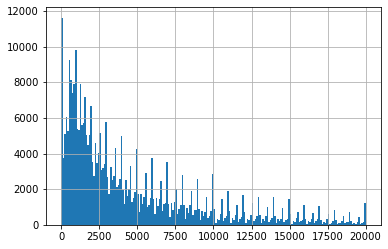

In [20]:
df['Price'].hist(bins=200)

In [21]:
# нули в столбце 'Price'
df.loc[df['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Actuality
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0,19348,4
40,0,unknown,1990,unknown,68,corsa,150000,1,petrol,opel,unknown,0,56412,1
115,0,small,1999,unknown,74,unknown,5000,0,petrol,volkswagen,unknown,0,37520,18
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,0,27432,1
154,0,unknown,2006,unknown,129,other,5000,0,unknown,fiat,unknown,0,44867,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,0,unknown,2000,manual,65,corsa,150000,0,unknown,opel,yes,0,23758,21
354238,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,0,33659,17
354248,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,0,42329,14
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,0,22559,2


In [22]:
df.loc[df['Price'] == 0, ['Price']] = np.nan # превратим нули в пропуски
df['Price'] = np.where(df['Price'].isnull(), df['Model'].map(df.groupby('Model')['Price'].mean()), df['Price'])
                                                                                   
df.loc[df['Price'].isnull()].head() # пропуски заполнены                                                                          

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,Actuality


In [23]:
# выделение целевого признака
target = df['Price']
features = df.drop(['Price'], axis=1)

In [24]:
# разделение на тестовую и тренировочную выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [25]:
# закодированные категориальные признаки помечены цифрой 1
# выделение целевого признака
# разделение на тестовую и тренировочную выборки
target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop(['Price'], axis=1)
features_train1, features_test1, target_train1, target_test1 = train_test_split(
    features_ohe, target_ohe, test_size=0.4, random_state=12345)

## Обучение моделей

In [26]:
%%time
# линейная регрессия
model = LinearRegression() # инициализация модели
model.fit(features_train1, target_train1) # обучение модели на тренировочной выборке

Wall time: 11.1 s


LinearRegression()

In [28]:
%%time
# линейная регрессия
predictions = model.predict(features_test1) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test1, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 2766.8207489249016
Wall time: 660 ms


In [29]:
%%time
#DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(features_train1, target_train1) # обучение модели на тренировочной выборке

Wall time: 18.4 s


DecisionTreeRegressor()

In [32]:
%%time
#DecisionTreeRegressor
predictions = model.predict(features_test1) # предсказания модели на тестовой выборке
mse = mean_squared_error(target_test1, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 2279.084204071332
Wall time: 897 ms


In [33]:
%%time
#cat boost
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
model = CatBoostRegressor(loss_function='RMSE', iterations=200)
model.fit(features_train, target_train, cat_features=cat_features, verbose=30)

Learning rate set to 0.349389
0:	learn: 3536.0348338	total: 795ms	remaining: 2m 38s
30:	learn: 1782.6255459	total: 13.3s	remaining: 1m 12s
60:	learn: 1700.4297417	total: 26.3s	remaining: 59.9s
90:	learn: 1660.7346091	total: 37.9s	remaining: 45.4s
120:	learn: 1635.1680651	total: 51.3s	remaining: 33.5s
150:	learn: 1612.8779656	total: 1m 2s	remaining: 20.4s
180:	learn: 1594.7045208	total: 1m 15s	remaining: 7.89s
199:	learn: 1583.8562420	total: 1m 22s	remaining: 0us
Wall time: 1min 24s


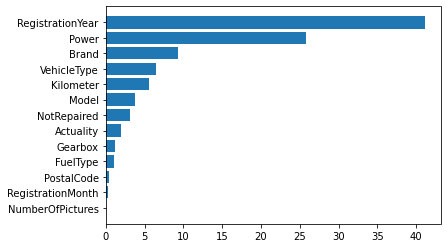

In [36]:
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

In [37]:
%%time
#cat boost
predictions = model.predict(features_test)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 1652.227087249474
Wall time: 815 ms


In [38]:
%%time
#cat boost c заранее закодированными категориальными переменными
model = CatBoostRegressor(loss_function='RMSE', iterations=200) 
model.fit(features_train1, target_train1, verbose=30)

Learning rate set to 0.349389
0:	learn: 3592.4105924	total: 56.9ms	remaining: 11.3s
30:	learn: 1840.3140223	total: 1.4s	remaining: 7.63s
60:	learn: 1759.7052494	total: 2.74s	remaining: 6.24s
90:	learn: 1710.4061156	total: 4.11s	remaining: 4.92s
120:	learn: 1678.1551529	total: 6.22s	remaining: 4.06s
150:	learn: 1651.9719130	total: 7.72s	remaining: 2.5s
180:	learn: 1631.5796759	total: 9.22s	remaining: 968ms
199:	learn: 1621.1862367	total: 10s	remaining: 0us
Wall time: 12 s


In [39]:
%%time
#cat boost c заранее закодированными категориальными переменными
predictions = model.predict(features_test1)
mse = mean_squared_error(target_test1, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 1701.2329880847883
Wall time: 465 ms


In [40]:
#%%time
#params_cb = {'learning_rate': [0.1, 0.3, 0.5], 'depth':[5, 10, 15]}
#model_cb = CatBoostRegressor(loss_function='RMSE', iterations=50)
#grid_cb = GridSearchCV(model_cb, params_cb, cv=5, n_jobs=-1)
#grid_cb.fit(features_train, target_train, cat_features=cat_features, verbose=20)
#grid_cb.best_params_

In [41]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'verbose': 100,
    "max_depth": 8,
    "max_bin": 512,
    "num_iterations": 200
    
}

In [42]:
%%time
#LGBM с OHE
gbm = ltb.LGBMRegressor(**hyper_params)
gbm.fit(features_train1, target_train1)

C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.903875
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.359683
[LightGBM] [Debug] init for col-wise cost 0.009576 seconds, init for row-wise cost 0.037570 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 197981, number of used features: 294
[LightGBM] [Info] Start training from score 4537.456367
[LightGBM] [Debug] Trai

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Traine

LGBMRegressor(max_bin=512, max_depth=8, metric=['l1', 'l2'], num_iterations=200,
              objective='regression', task='train', verbose=100)

In [43]:
predictions = gbm.predict(features_test1, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test1, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 1714.9669120426659


In [44]:
# переведем категорииальные признаки в формат, понятный LGBM
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    features_test[c] = features_test[c].astype('category')

C:\Users\dande\AppData\Local\Temp/ipykernel_6228/283416577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[c] = features_train[c].astype('category')
C:\Users\dande\AppData\Local\Temp/ipykernel_6228/283416577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[c] = features_test[c].astype('category')


In [45]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197981 entries, 200383 to 233640
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        197981 non-null  category
 1   RegistrationYear   197981 non-null  int64   
 2   Gearbox            197981 non-null  category
 3   Power              197981 non-null  int64   
 4   Model              197981 non-null  category
 5   Kilometer          197981 non-null  int64   
 6   RegistrationMonth  197981 non-null  int64   
 7   FuelType           197981 non-null  category
 8   Brand              197981 non-null  category
 9   NotRepaired        197981 non-null  category
 10  NumberOfPictures   197981 non-null  int64   
 11  PostalCode         197981 non-null  int64   
 12  Actuality          197981 non-null  int32   
dtypes: category(6), int32(1), int64(6)
memory usage: 12.7 MB


In [46]:
%%time
gbm = ltb.LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\dande\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.737498
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.150342
[LightGBM] [Debug] init for col-wise cost 0.005358 seconds, init for row-wise cost 0.020305 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 197981, number of used features: 12
[LightGBM] [Info] Start training from score 4652.447346
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[Lig

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Traine

LGBMRegressor(max_bin=512, max_depth=8, metric=['l1', 'l2'], num_iterations=200,
              objective='regression', task='train', verbose=100)

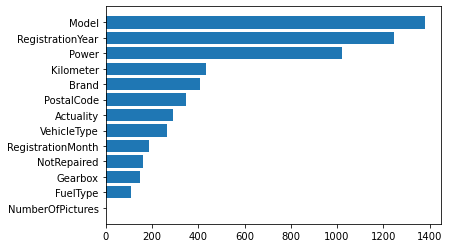

In [47]:
importances = gbm.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

In [48]:
%%time
predictions = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
mse = mean_squared_error(target_test, predictions)
print("RMSE =", mse ** 0.5)

RMSE = 1622.2287897025485
Wall time: 1.53 s


Модель мучительно долго обучалась, зато метрика RMSE получилась минимальной - 1740.

## Анализ моделей

Самый лучший результат на тестовой выборке показала модель LGBMRegressor, но она дольше всех обучалась - 18 минут, 300 итераций. При большем количестве итераций результат был ещё лучше, но ненамного и длительность обучения выходила за грани разумного. Кроме того, хороший результат был у CatBoost, при этом модель лучше работала на необработанных категориальных признаках, чем на признаках после прямого кодирования